In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split

<ipython-input-1-38939910a397>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
url = 'https://raw.githubusercontent.com/DavGev/OMDS_project/master/data.txt'
data = pd.read_csv(url)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
X = data.loc[data.Y.isin(['A', 'G']), data.columns != 'Y']
y = data.loc[data.Y.isin(['A', 'G']), 'Y']
y = pd.get_dummies(y)['G']

X = X.to_numpy()
y = y.to_numpy()


# PART 1 - MLP

- $ E(ω;π) = - \frac{1}{P} ∑_{i=1}^P {[y_i \ln(p_i) + (1 - y_i) \ln(1 - p_i)]} + ρ \|ω\|^2 $
- $ ρ = 10^{−4} $
- $ S(v)_j = \frac{e^{v_j}}{∑_{h=1}^n e^{v_h}} $
- The activation function $g(t) := tanh(t)$

### Hyperparameters
- the number H of hidden layers (max. 4) (only for question 1)
- the number of neurons N of the hidden layers
- the spread $σ > 0$ in the activation function $g$ ($g$ is available in Python with $σ = 1$: `numpy.tanh`)

### Tasks
- Write a program which implements the regularized training error function $E(v,w,b)$
- **Question 1. (grade up to 20)** Use an optimization algorithm from `scipy.optimize` that uses the gradient to determine the parameters $v_j ,w_{ji}, b_j$ which minimize the error.
- **Question 2. (grade up to 10)** Develop an RBF neural network trained by implementing the decomposition method studied in class.

| Ex | H | N | $σ$ | $ρ$ | Optimization | Message | Init train error | Final train error | Final  test error | f\grad evaluations | Time |
| -|-|-|-|-|-|-|-|-|-|-|-|
| Q1 Full MLP |
| Q2 RBF |


\* optimization: with parameters (optimality accuracy, max number of iterations etc)

\* message: in output (successful optimization or others, number of iterations, number of function/gradient evaluations, starting/final value of the objective function, starting/final accuracy etc)

In [69]:
class Sigmoid:
    def __call__(self, x):
        return 1 / (1 + np.exp(-x, dtype=np.float128)) # dtype=np.float128 to prevent rounding up to 0 or 1

    def grad(self, s_x):
        return s_x * (1 - s_x)


class Tanh:
    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, x):
        return np.tanh(self.sigma * x)

    def grad(self, th_x):
        return self.sigma * (1 - th_x ** 2)


In [70]:
class MLPLayer():
    def __init__(self, input_size, output_size, activation):
        self.w = np.random.random((output_size, input_size)) * 0.01
        self.w /= (self.w ** 2).sum() ** 0.5
        self.activation = activation

        self.input = None
        self.output = None
        self.grad_w = None
        self.grad_input = None


    def Forward(self, input):
        self.input = np.insert(input, 0, 1, axis=-1)
        sum = self.input @ self.w.T
        self.output = self.activation(sum)


    def Backward(self, grad_output):
        grad_sum = self.activation.grad(self.output) * grad_output
        self.grad_w = grad_sum.T @ self.input
        self.grad_input = grad_sum @ self.w[:,1:]


In [73]:
class MLP():
    def __init__(self, N, sigma=10):
        '''
        N: array of numbers of neurons in the input layer,
        each hiden layer and the output layer

        For example if our data is 10 dimentional, we need two hidden layers
        with 5 neurons, and we have 2 classes, than N = [10, 5, 5, 2]
        '''
        self.rho = 1e-4
        self.layers = [
            MLPLayer(
                input_size = N[i] + 1,
                output_size = N[i+1],
                activation = Tanh(sigma)
            ) for i in range(len(N) - 1)
        ]
        self.layers[-1].activation = Sigmoid()


    def assign_w(self, w):
        '''
        w: flattened array of all the weights
        '''
        start = 0
        end = 0
        for layer in self.layers:
            end += layer.w.size
            layer.w = w[start : end].reshape(layer.w.shape)
            start = end


    def get_flat(self, what):
        if what == 'w':
            return np.concatenate([layer.w.flatten() for layer in self.layers])
        if what == 'grad_w':
            return np.concatenate([layer.grad_w.flatten() for layer in self.layers])


    def predict(self, X):
        ipnut = X
        for layer in self.layers:
            layer.Forward(ipnut)
            ipnut = layer.output
        return ipnut


    def error(self, X, y):
        y = y.reshape([-1, 1])
        p = self.predict(X)
        error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
        error += self.rho * (self.get_flat('w') ** 2).sum()
        return error


    def gradient(self, X, y):
        y = y.reshape([-1, 1])
        p = self.predict(X)
        grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
        for layer in self.layers[::-1]:
            layer.Backward(grad_output)
            grad_output = layer.grad_input

        grad = self.get_flat('grad_w')
        grad += 2 * self.rho * self.get_flat('w')
        return grad


    def fit(self, X, y, method='TNC'):

        def fun(w):
            self.assign_w(w)
            return self.error(X, y)

        def jac(w):
            self.assign_w(w)
            return self.gradient(X, y)

        w0 = self.get_flat('w')
        message = minimize(fun=fun, jac=jac, x0=w0, method=method)
        self.assign_w(message.x)
        return message


    def accuracy(self, X, y, threshold=0.5):
        y = y.reshape([-1, 1])
        p = self.predict(X)
        return ((p > threshold) == y).mean()


### Some observations on the minimization methods

|method|speed|comment|
|-|-|-|
|`'Nelder-Mead'`|slow|stabile, accuracy = 0.505|
|`'Powell'`|very slow| accuracy > 0.93|
|`'CG'`|very slow|very unstabile, sometimes accuracy < 0.5|
|`'BFGS'`|fast| unstabile, sometimes accuracy = 0.505|
|`'Newton-CG'`|not too fast| quite stabile, mostly accuracy > 0.97|
|`'L-BFGS-B'`||just an error|
|`'TNC'`|very fast| quite stabile, mostly accuracy > 0.96|
|`'COBYLA'`|too fast| mostly accuracy = 0.505|
|`'SLSQP'`|lightning fast| accuracy = 0.505|
|`'trust-constr'`|not too fast| mostly accuracy > 0.995|
|`'dogleg'`||we need Hessian|
|`'trust-ncg'`||we need Hessian|
|`'trust-exact'`||we need Hessian|
|`'trust-krylov'`||we need Hessian|

After consideration, I chose `'TNC'` to be the default method of minimization

In [ ]:
for i in range(20):
    model = MLP([16, 2, 1])
    model.fit(X, y, 'trust-constr')
    print(f'{i}: {model.accuracy(X, y)}')

## Cross Validation

In [74]:
np.random.seed(42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [75]:
models_data = []
for N_layers in tqdm(range(5)):
    for N_neurons in tqdm(range(4, 17, 4) if N_layers != 0 else range(1)):
        N = [16] + [N_neurons] * N_layers + [1]

        for log_sigma in tqdm(range(-2, 3)):
            sigma = 10 ** log_sigma

            kf = KFold(n_splits=5, shuffle=True)
            kf.get_n_splits(X_train_val)

            for train_index, valid_index in kf.split(X_train_val):
                scaler = StandardScaler()
                model = MLP(N, sigma)

                X_train = X_train_val[train_index]
                y_train = y_train_val[train_index]
                X_val = X_train_val[valid_index]
                y_val = y_train_val[valid_index]

                X_train_scaled = scaler.fit_transform(X_train)
                model.fit(X_train_scaled, y_train)
                train_error = model.error(X_train_scaled, y_train)

                X_val_scaled = scaler.transform(X_val)
                val_error = model.error(X_val_scaled, y_val)

                models_data.append({'N_layers': N_layers,
                                    'N_neurons': N_neurons,
                                    'sigma': sigma,
                                    'train_error': train_error,
                                    'val_error': val_error})

                pd.DataFrame(models_data).to_csv('/content/drive/MyDrive/Colab Notebooks/models_data.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * n

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: divide by zero encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-70-9382234eb007>:20: RuntimeWarning: invalid value encountered in multiply
  grad_sum = self.activation.grad(self.output) * grad_output


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: divide by zero encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-70-9382234eb007>:20: RuntimeWarning: invalid value encountered in multiply
  grad_sum = self.activation.grad(self.output) * grad_output
<ipython-input-69-3175a088196b>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) # dtype=np.float128 to prevent rounding up to 0 or 1
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-69-3175a088196b>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) # dtype=np.floa

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: divide by zero encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-70-9382234eb007>:20: RuntimeWarning: invalid value encountered in multiply
  grad_sum = self.activation.grad(self.output) * grad_output


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: divide by zero encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-70-9382234eb007>:20: RuntimeWarning: invalid value encountered in multiply
  grad_sum = self.activation.grad(self.output) * grad_output
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + 

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: divide by zero encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-69-3175a088196b>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) # dtype=np.float128 to prevent rounding up to 0 or 1
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: invalid value encountered in multiply
  error = - (y * np.log(p) + (1-y) * np.log(1-p)).mean()
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: divide by zero encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-73-de60a8715a25>:59: RuntimeWarning: invalid value encountered in true_divide
  grad_output = - (y / p - (1-y) / (1-p)) / X.shape[0]
<ipython-input-70-9382234eb007>:20: RuntimeWarning: invalid value encountered in multiply
  grad_sum = self.activation.grad(self.output) * grad_output
<ipython-input-73-de60a8715a25>:51: RuntimeWarning: divide by zero encountered in log
  error = - (y

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [78]:
models_data = pd.DataFrame(models_data)
models_data.head()

,N_layers,N_neurons,sigma,train_error,val_error
0,0,0,0.01,0.022727,0.070397
1,0,0,0.01,0.039773,0.032127
2,0,0,0.01,0.026402,0.050326
3,0,0,0.01,0.031141,0.040200
4,0,0,0.01,0.039341,0.044731


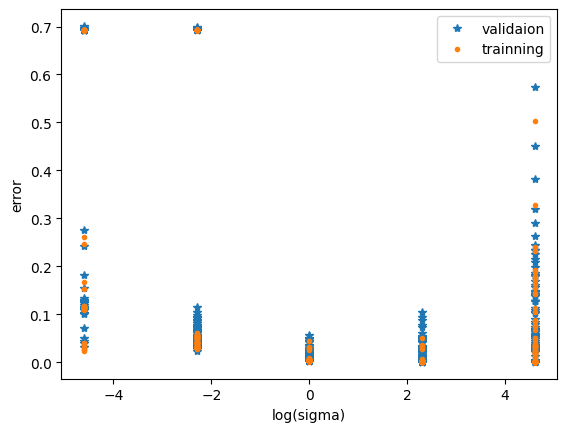

In [119]:
plt.xlabel('log(sigma)')
plt.ylabel('error')
plt.plot(np.log(models_data.sigma), models_data.val_error, '*', label='validaion')
plt.plot(np.log(models_data.sigma), models_data.train_error, '.', label='trainning')
plt.legend()
plt.show()

Clearly sigma = 1 is the best

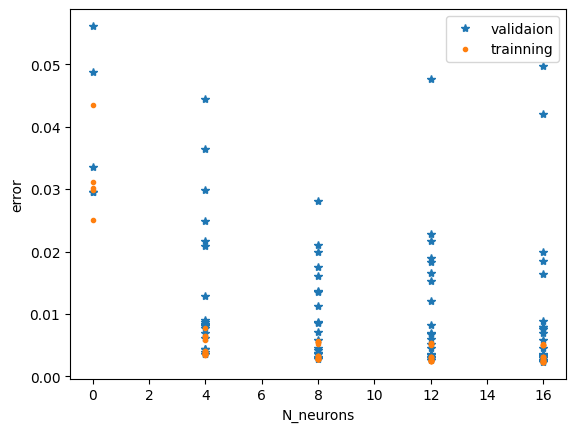

In [118]:
plt.xlabel('N_neurons')
plt.ylabel('error')
plt.plot(models_data.loc[models_data.sigma == 1].N_neurons,
         models_data.loc[models_data.sigma == 1].val_error,
         '*', label='validaion')
plt.plot(models_data.loc[models_data.sigma == 1].N_neurons,
         models_data.loc[models_data.sigma == 1].train_error,
         '.', label='trainning')
plt.legend()
plt.show()

For number of neurons both 8 and 12 are good

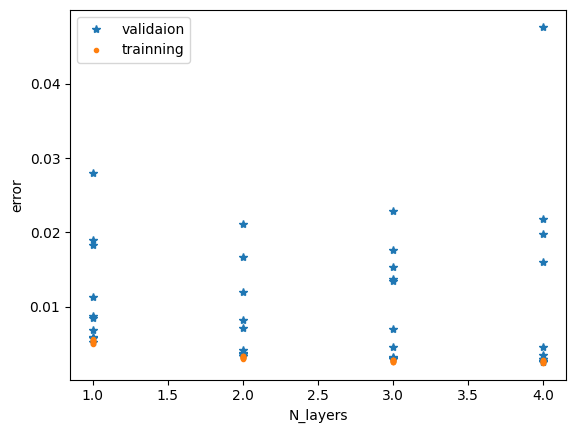

In [120]:
plt.xlabel('N_layers')
plt.ylabel('error')
plt.plot(models_data.loc[models_data.sigma == 1].loc[models_data.N_neurons.isin([8, 12])].N_layers,
         models_data.loc[models_data.sigma == 1].loc[models_data.N_neurons.isin([8, 12])].val_error,
         '*', label='validaion')
plt.plot(models_data.loc[models_data.sigma == 1].loc[models_data.N_neurons.isin([8, 12])].N_layers,
         models_data.loc[models_data.sigma == 1].loc[models_data.N_neurons.isin([8, 12])].train_error,
         '.', label='trainning')
plt.legend()
plt.show()

For number of layers 2 is the best

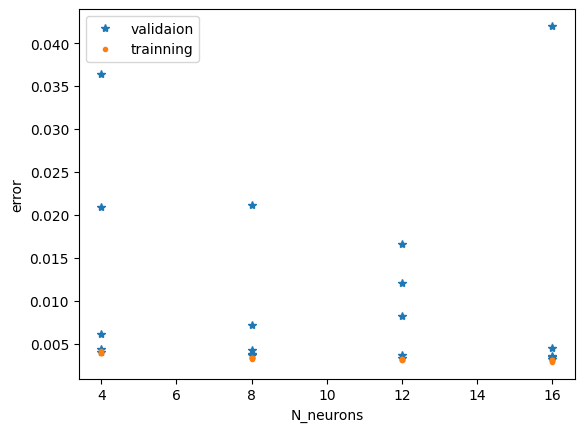

In [121]:
plt.xlabel('N_neurons')
plt.ylabel('error')
plt.plot(models_data.loc[models_data.sigma == 1].loc[models_data.N_layers == 2].N_neurons,
         models_data.loc[models_data.sigma == 1].loc[models_data.N_layers == 2].val_error,
         '*', label='validaion')
plt.plot(models_data.loc[models_data.sigma == 1].loc[models_data.N_layers == 2].N_neurons,
         models_data.loc[models_data.sigma == 1].loc[models_data.N_layers == 2].train_error,
         '.', label='trainning')
plt.legend()
plt.show()

And finally I choose the number of neurons to be 8